In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import numpy as np
import itertools
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier

'''
Disclaimer: the following code is adapted from 
https://github.com/parthpatwa/covid19-fake-news-detection

@misc{patwa2020fighting,
title={Fighting an Infodemic: COVID-19 Fake News Dataset}, 
author={Parth Patwa and Shivam Sharma and Srinivas PYKL and Vineeth Guptha and Gitanjali Kumari and Md Shad Akhtar and Asif Ekbal and Amitava Das and Tanmoy Chakraborty},
year={2020},
eprint={2011.03327},
archivePrefix={arXiv},
primaryClass={cs.CL}
}
'''

'\nDisclaimer: the following code is adapted from \nhttps://github.com/parthpatwa/covid19-fake-news-detection\n\n@misc{patwa2020fighting,\ntitle={Fighting an Infodemic: COVID-19 Fake News Dataset}, \nauthor={Parth Patwa and Shivam Sharma and Srinivas PYKL and Vineeth Guptha and Gitanjali Kumari and Md Shad Akhtar and Asif Ekbal and Amitava Das and Tanmoy Chakraborty},\nyear={2020},\neprint={2011.03327},\narchivePrefix={arXiv},\nprimaryClass={cs.CL}\n}\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# lazy install stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# cleaning and split the text
def text_clean(text):
    ''' Pre process and convert texts to a list of words '''
    
    text=text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"I'm", "I am ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"wouldn't", "would not ", text)
    text = re.sub(r"shouldn't", "should not ", text)
    text = re.sub(r"shouldn", "should not ", text)
    text = re.sub(r"didn", "did not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('https?://\S+|www\.\S+', "", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"[0-9]", "", text)
  
    return text

In [ ]:
# load dataset
train = pd.read_excel('/content/drive/MyDrive/dataset/english_training_set.xlsx')
val = pd.read_excel('/content/drive/MyDrive/dataset/english_validation_set.xlsx')
test = pd.read_excel('/content/drive/MyDrive/dataset/english_testing_set_with_labels.xlsx')

In [ ]:
# clean and split the dataset
train['tweet'] = train['tweet'].map(lambda x: text_clean(x))
val['tweet'] = val['tweet'].map(lambda x: text_clean(x))
test['tweet'] = test['tweet'].map(lambda x: text_clean(x))

In [ ]:
# method for printing performance
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))
    
    

Logistic Regression
test:
[[ 940   80]
 [ 105 1015]]
              precision    recall  f1-score   support

        fake       0.90      0.92      0.91      1020
        real       0.93      0.91      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.9135514018691588
Precison :  0.9137303577973245
Recall :  0.9135514018691588
F1 :  0.913515964176234


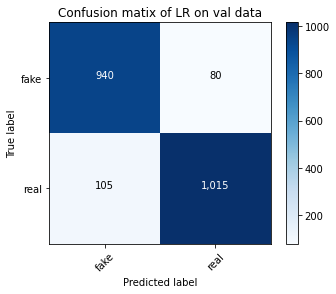

In [ ]:
# Running Logistic Regression
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', LogisticRegression())
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Logistic Regression')
print ('test:')
pred=pipeline.predict(test['tweet'])

print_metrices(pred,test['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of LR on val data')

Gradient Boost
test:
[[909 111]
 [183 937]]
              precision    recall  f1-score   support

        fake       0.83      0.89      0.86      1020
        real       0.89      0.84      0.86      1120

    accuracy                           0.86      2140
   macro avg       0.86      0.86      0.86      2140
weighted avg       0.86      0.86      0.86      2140

Accuracy :  0.8626168224299066
Precison :  0.8644527998115135
Recall :  0.8626168224299066
F1 :  0.8625563341975816


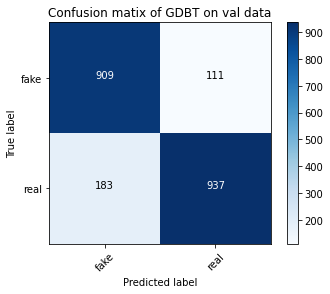

In [ ]:
# Running Gradient Boost
# May have minor variations due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', GradientBoostingClassifier())
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Gradient Boost')
print ('test:')
pred=pipeline.predict(test['tweet'])
print_metrices(pred,test['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of GDBT on val data')

Decision Tree
test:
[[823 197]
 [176 944]]
              precision    recall  f1-score   support

        fake       0.82      0.81      0.82      1020
        real       0.83      0.84      0.84      1120

    accuracy                           0.83      2140
   macro avg       0.83      0.82      0.83      2140
weighted avg       0.83      0.83      0.83      2140

Accuracy :  0.8257009345794393
Precison :  0.8260541506322155
Recall :  0.8257009345794393
F1 :  0.8257979549306043


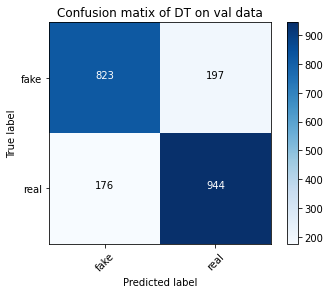

In [ ]:
# Running Decision Tree
# May have minor variations due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', tree.DecisionTreeClassifier())
    ])
fit = pipeline.fit(train['tweet'],train['label'])

print('Decision Tree')
print ('test:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred, val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of DT on val data')

Random Forest
test:
[[926  94]
 [137 983]]
              precision    recall  f1-score   support

        fake       0.87      0.91      0.89      1020
        real       0.91      0.88      0.89      1120

    accuracy                           0.89      2140
   macro avg       0.89      0.89      0.89      2140
weighted avg       0.89      0.89      0.89      2140

Accuracy :  0.8920560747663552
Precison :  0.8926621852011832
Recall :  0.8920560747663552
F1 :  0.8919982622076708


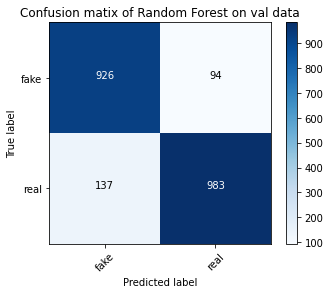

In [ ]:
# Running Random Forest
# May have minor variations due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', RandomForestClassifier())
    ])
fit = pipeline.fit(train['tweet'],train['label'])

print('Random Forest')
print ('test:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of Random Forest on val data')